In [5]:
#import required library
import numpy as np
import random
import os
import glob
from PIL import Image 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm

In [6]:
device=('cuda' if torch.cuda.is_available() else 'cpu')
print('model is running on:',device)

model is running on: cpu


In [27]:
# Define Siamese Network Architecture using torch.nn.Module
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.subnetwork1 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=7,stride=2,padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64, kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2))
        
        self.subnetwork2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32,8,kernel_size=1,stride=1),
            nn.ReLU(inplace=True))

        
        self.fc= nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(inplace=True))
                
        self.fc_embedding = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(512,32))
        
    
    def forward_one(self, x):
        x = self.subnetwork1(x)
        x = self.subnetwork2(x)
        x=x.view(x.size(0),-1)     #flatten the cnn layer
        x = self.fc(x)
        x = self.fc_embedding(x)
        x=nn.functional.normalize(x, p=2, dim=1)   #embedding normalized to make unit vector(have magnitutde=1)
        return x

    def forward(self, anchor_input, pos_input,neg_input):
        anchor_output = self.forward_one(anchor_input)
        pos_output = self.forward_one(pos_input)
        neg_output = self.forward_one(neg_input)
        return anchor_output, pos_output,neg_output


In [28]:
siamese_model=SiameseNetwork()
siamese_model.to(device)

SiameseNetwork(
  (subnetwork1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (subnetwork2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding

In [29]:
# Creating a Custom Dataset module for triplet loss for our siamese network
class Siamese_triplet_Dataset(Dataset):
    def __init__(self, imgpath_list,train_transform=None,test_transform=None):
        super(Siamese_triplet_Dataset,self).__init__()
        self.imgpath_list = imgpath_list
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.num_labels=self.imgpath_list[0]

    def __len__(self):
        return len(self.imgpath_list)

    def __getitem__(self, idx):
        label_list= list(np.arange(start=0,stop=len(self.imgpath_list[idx]),step=1))
        anchor_class_index=random.choice(label_list)
        label_list.remove(anchor_class_index)
        neg_class_index=random.choice(label_list)
        
        img_anchor= Image.open(self.imgpath_list[idx][anchor_class_index])
        img_neg= Image.open(self.imgpath_list[idx][neg_class_index])
        img_pos= Image.open(self.imgpath_list[random.choice(np.arange(start=0,stop=len(self.imgpath_list),step=1))][anchor_class_index])
        
        
        if self.train_transform:
            img_anchor = self.train_transform(img_anchor)
            img_pos = self.train_transform(img_pos)
            img_neg = self.train_transform(img_neg)
            
        elif self.test_transform:
            img_anchor = self.test_transform(img_anchor)
            img_pos = self.test_transform(img_pos)
            img_neg = self.test_transform(img_neg)
            
        return img_anchor, img_pos, img_neg





In [30]:
#define image augmentation transformation

train_trans=transforms.Compose([transforms.Resize(size=(299,299)),
                   transforms.RandomResizedCrop(size=(299,299)),
                   transforms.RandomAffine(degrees=5),
                   transforms.ColorJitter(),
                   transforms.RandomHorizontalFlip(p=0.25),
                   transforms.RandomVerticalFlip(p=0.25),
                   transforms.RandomGrayscale(p=0.15),
                   transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 2.0)),
                   transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.1),                           
                   transforms.ToTensor(),
                   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_trans=transforms.Compose([transforms.Resize(size=(299,299)),                           
                   transforms.ToTensor(),
                   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


In [31]:
#define function for image data folder reader
def datafolder_reader(datafolder_rootpath):
    sub_folder_list=os.listdir(datafolder_rootpath)
    classes_rootpath=[os.path.join(datafolder_rootpath,class_id) for class_id in sub_folder_list if class_id != '.DS_Store']
    number_of_classes=len(classes_rootpath)
    print('number of class labels:',number_of_classes)
 
    dictt={}
    # Define the allowed extensions
    allowed_extensions = ["jpg",'JPEG' "png",'PNG']
    for class_path in classes_rootpath:
        # Create a list to store the file paths
        image_paths = []
        for ext in allowed_extensions:
            pattern = f"{class_path}/*.{ext}"    
            image_paths.extend(glob.glob(pattern)) 
        dictt[os.path.basename(class_path)]=image_paths
     

    #as we had 4 classes so we zipped all four class and took one-one sample from each class
    classes=list(dictt.keys())
    print(classes)
    image_path_list=[(img_path_cls1,img_path_cls2,img_path_cls3,img_path_cls4) for img_path_cls1,img_path_cls2,img_path_cls3,img_path_cls4 in zip(dictt[classes[0]],dictt[classes[1]],dictt[classes[2]],dictt[classes[3]])] 
    return image_path_list

In [32]:
# get the images path for train and test datatset
train_image_list=datafolder_reader(datafolder_rootpath='/Users/kamlesh.sahu/Downloads/car_/train')
test_image_list=datafolder_reader(datafolder_rootpath='/Users/kamlesh.sahu/Downloads/car_/test')

number of class labels: 4
['right', 'back', 'left', 'front']
number of class labels: 4
['right', 'back', 'left', 'front']


In [33]:
train_image_list,test_image_list

([('/Users/kamlesh.sahu/Downloads/car_/train/right/frame42_0017.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/back/IMG_20221201_150458 - Ashwinkumar A.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/left/frame19_0033.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/front/frame30_0020.jpg'),
  ('/Users/kamlesh.sahu/Downloads/car_/train/right/image18_0024.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/back/image35_0001.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/left/image23_0013.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/front/frame13_0030.jpg'),
  ('/Users/kamlesh.sahu/Downloads/car_/train/right/frame18_0027.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/back/image28_0004.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/left/image22_0007.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/front/frame12_0019.jpg'),
  ('/Users/kamlesh.sahu/Downloads/car_/train/right/image34_0029.jpg',
   '/Users/kamlesh.sahu/Downloads/car_/train/back/image15_0056.jpg',
 

In [34]:
# get the train data loader 
train_data = Siamese_triplet_Dataset(imgpath_list=train_image_list, train_transform=train_trans)
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)


In [35]:
# get the test data loader 
test_data = Siamese_triplet_Dataset(imgpath_list=test_image_list, test_transform=test_trans)
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

In [37]:
# define triplet loss function
pairwise_distance = nn.PairwiseDistance(p=2,keepdim=False)  #sqrt((x1-x2)*2+(y1-y2)*2 +(z1-z2)*2+.....) qualidian distance

def triplet_losss(anchor_embedding,pos_embedding,neg_embedding, margin=0.8,reduction='mean'):
    dis_pos = pairwise_distance(anchor_embedding, pos_embedding)
    dis_neg = pairwise_distance(anchor_embedding, neg_embedding)
    
    loss_list=torch.relu((dis_pos-dis_neg)+ margin)
    if reduction=='mean':
        loss=torch.mean(loss_list)
    else:
        loss=torch.sum(loss_list)
    return loss

In [42]:
# define adam optimizer and learing rate scheduler
from torch.optim import Adam
from torch.optim import lr_scheduler


optimizer=Adam(params=siamese_model.parameters(),lr=0.01)
scheduler=lr_scheduler.ExponentialLR(optimizer,gamma=0.9)

In [43]:
print('Training has started.....')
EPOCH_NUMBER=50

training_loss_history=[]
val_loss_history=[]

for epoch in range(0,EPOCH_NUMBER):
    train_running_loss = 0.0
    test_running_loss=0.0
    for anchor_img,pos_img,neg_img in train_dataloader:
        optimizer.zero_grad()
        anchor_img=anchor_img.to(device)
        pos_img=pos_img.to(device)
        neg_img=neg_img.to(device)
        
        img_anchor_embedd, img_pos_embedd, img_neg_embedd=siamese_model(anchor_input=anchor_img,pos_input=pos_img,neg_input=neg_img)
        loss = triplet_losss(img_anchor_embedd, img_pos_embedd, img_neg_embedd)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    scheduler.step()
    
    siamese_model.eval()
    for anchor_img,pos_img,neg_img in test_dataloader:
        anchor_img=anchor_img.to(device)
        pos_img=pos_img.to(device)
        neg_img=neg_img.to(device)
        img_anchor_embedd, img_pos_embedd, img_neg_embedd=siamese_model(anchor_input=anchor_img,pos_input=pos_img,neg_input=neg_img)
        test_loss = triplet_losss(img_anchor_embedd, img_pos_embedd, img_neg_embedd)
        test_running_loss += test_loss.item()

    
    train_epoch_loss = train_running_loss / len(train_dataloader)
    training_loss_history.append(train_epoch_loss)
    
    test_epoch_loss = test_running_loss / len(test_dataloader)
    val_loss_history.append(test_epoch_loss)
    
    print(f"Epoch: [{epoch+1}/{EPOCH_NUMBER}], Train_Loss: {train_epoch_loss:.3f} , Val_Loss: {test_epoch_loss:.3f}")
    

Training has started.....
Epoch: [1/50], Train_Loss: 0.817 , Val_Loss: 0.794
Epoch: [2/50], Train_Loss: 0.801 , Val_Loss: 0.801
Epoch: [3/50], Train_Loss: 0.800 , Val_Loss: 0.794
Epoch: [4/50], Train_Loss: 0.803 , Val_Loss: 0.788
Epoch: [5/50], Train_Loss: 0.801 , Val_Loss: 0.793
Epoch: [6/50], Train_Loss: 0.798 , Val_Loss: 0.798
Epoch: [7/50], Train_Loss: 0.796 , Val_Loss: 0.790
Epoch: [8/50], Train_Loss: 0.796 , Val_Loss: 0.795
Epoch: [9/50], Train_Loss: 0.800 , Val_Loss: 0.793
Epoch: [10/50], Train_Loss: 0.796 , Val_Loss: 0.785
Epoch: [11/50], Train_Loss: 0.801 , Val_Loss: 0.797
Epoch: [12/50], Train_Loss: 0.792 , Val_Loss: 0.771
Epoch: [13/50], Train_Loss: 0.798 , Val_Loss: 0.777
Epoch: [14/50], Train_Loss: 0.797 , Val_Loss: 0.764
Epoch: [15/50], Train_Loss: 0.783 , Val_Loss: 0.751
Epoch: [16/50], Train_Loss: 0.797 , Val_Loss: 0.745
Epoch: [17/50], Train_Loss: 0.790 , Val_Loss: 0.765
Epoch: [18/50], Train_Loss: 0.792 , Val_Loss: 0.768
Epoch: [19/50], Train_Loss: 0.783 , Val_Loss: 0

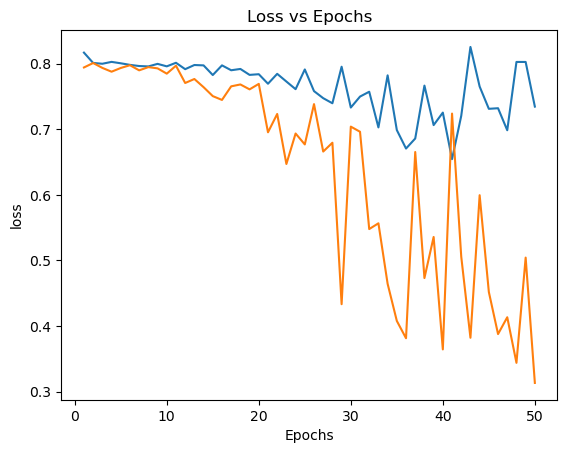

In [44]:
#plot the training and validation loss w.r.t. epochs
epoches = np.arange(1, len(training_loss_history)+1, step=1, dtype=int)
plt.plot(epoches, training_loss_history)
plt.plot(epoches, val_loss_history)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [45]:
# Specify the path where you want to save the model weights
save_path = 'model_siamese.pth'
# Save only the model's state_dict (parameters)
#torch.save(siamese_model.state_dict(), save_path)